In [1]:
from keras.preprocessing.text import text_to_word_sequence
import pandas as pd
from keras.preprocessing.text import Tokenizer
import numpy as np
import os
import collections
import re
import string
import nltk
from nltk import word_tokenize, WordNetLemmatizer
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from nltk.corpus import stopwords
from keras.callbacks import EarlyStopping

from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers import Embedding
from keras.layers import Conv1D, GlobalMaxPooling1D, MaxPooling1D
from gensim.models import Word2Vec
from gensim import models
from keras.layers import Dense, Dropout, Reshape, Flatten, concatenate, Input, Embedding
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model


Using TensorFlow backend.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [2]:
d = pd.read_csv('D:/Tugas/Skripsi/dataSet.csv' , encoding='unicode_escape')

In [3]:
d.columns = ['id','tweet', 'label']

In [4]:
d.label.unique()

array(['Positif', 'Netral', 'Negatif'], dtype=object)

In [5]:
import nltk

In [6]:
from nltk import word_tokenize, WordNetLemmatizer

In [19]:
sinonim_tidak= {"krng":"tidak","kurng":"tidak","kurang":"tidak","suka":"bagus","ska":"bagus","nggak":"tidak","ngga":"tidak","gak":"tidak","ga":"tidak","g":"tidak","ngak":"tidak","enggak":"tidak","engga":"tidak"} 

In [20]:
def slang_tidak(text):  
    sentence_list = text.split()
    new_sentence = []
    for word in sentence_list:
      for candidate_replacement in sinonim_tidak:
        if candidate_replacement == word:
          word = word.replace(candidate_replacement, sinonim_tidak[candidate_replacement])
      new_sentence.append(word)
    return " ".join(new_sentence)

In [21]:
d['Text_slang'] = d['tweet'].apply(lambda x: slang_tidak(x))

In [22]:
def remove_num_file(text):
    text_nonum = ''
    text_nonum = re.sub(r'\d+','', text)
    return text_nonum

In [23]:
d['num'] = d['Text_slang'].apply(lambda x: remove_num_file(x))

In [24]:
kata_negasi = {'terlupakan' : 'ingat','jauh' : 'dekat','disarankan' : 'x','salah' : 'benar','pernah' : 'x','jadi' : 'x','ternyata' : 'x',
               'bisa' : 'x','boleh' : 'dilarang','begitu' : 'begini','mahal' : 'murah','terlalu' : 'x', 'karuan' : 'berantakan','rekomendasi' : 'jangan',
               'ramah' : '','sprti' : '','siasia' : 'berguna','besar' : 'kecil','bermain' : 'x','nyaman' : 'risih','berkunjung' : 'x', 'bawa' : 'x',
               'memadai' : '','kalah' : 'menang','nyesel' : '','jelas' : 'samar','ada' : 'x','terurus' : 'terlantar','mandi' : 'x','papa' : 'x','kenaik' : 'x',
               'enak' : 'tidakenak','suka' : 'duka','aman' : 'bahaya','tersentuh' : 'x','mau' : '','capek' : 'kuat','nyangka' : '','sengaja' : '','cocok' : '',
               'Kekurangannya' : 'kelebihannya','menemukan' : 'x','disangkasangka' : 'x','banyak' : 'sedikit','serame' : 'sepi','luas' : 'sempit','berani' : 'takut',
               'kecewa' : 'puas','fit' : 'sakit','untuk' : 'x','perlu' : 'x','membawa' : 'x','macet' : 'lancar','seperti' : 'x','rugi' : 'untung','pake' : 'x',
               'bersentuhan' : 'berjauhan','berpasir' : 'x','hari' : 'x','ke' : 'x','bosen' : 'senang','peduli' : 'acuh','bleh' : 'x','bayar' : 'gratis','dirawat' : 'dibiarkan',
               'menyediakan' : 'x','seneng' : 'sedih','rata' : 'kasar','hepi' : 'sedih','fresh' : 'layu','bingung' : 'faham','akan' : 'x','cukup' : 'kurang',
               'hijau' : 'x','d' : 'x','takutnya' : 'beraninya','tergelincir' : 'x','kesampaian' : 'gagal','lagi' : 'x','membayar' : 'gratis','pergi' : 'pulang','lebih' : 'x',
               'panas' : 'dingin','terlihat' : 'kasat','reomended' : 'jangan','hanya' : 'x','biasa' : '','di' : '','bertanggungjawab' : '','musim' : '','ramai' : 'sepi',
               'tahu' : 'x','yang' : 'x','terawat' : 'dibiarkan','menyarankan' : 'x','kepanasan' : 'kedinginan','murah' : 'mahal','tajam' : 'halus','putih' : 'x','berfungsi' : 'rusak',
               'berubah' : 'tetap','sebanyak' : 'sedikit','bocor' : 'x','bikin' : 'x','masuk' : 'keluar','jawab' : 'x','rekomen' : 'jangan','kedinginan' : 'kepanasan','berbahaya' : 'aman',
               'hati' : 'x','dapat' : 'susah','usah' : 'x','kelihatan' : 'kasat','musimhari' : 'x','dibawa' : 'x','kepenuhan' : 'longgar','kumuh' : 'bersih','tersedia' : 'x','tau' : 'x','atau' : 'x',
               'kuat' : 'lemah','dirusak' : 'dirawat','terbiasa' : 'x','bertanggung' : 'x','membahayakan' : 'aman','dalam' : 'x','ingin' : 'enggan','bagus' : 'jelek','sampai' : 'x','begiu' : 'x',
               'diperbolehkan' : 'dilarang','tertata' : 'berantakan','sedang' : 'x','prlu' : 'x','membuat' : 'x','kecewadan' : 'puas','tenang' : 'gelisah','langsung' : 'tunda','keras' : 'lunak',
               'banyaknya' : 'sedikitnya','berisik' : 'tenang','naik' : 'turun','bakal' : 'x','karena' : 'x','terlampau' : 'x','sesuai' : 'beda','kotor' : 'bersih','berenang' : 'x',
               'khawatir' : 'yakin','beraspal' : 'berbatu','masalah' : 'aman','dihitung' : 'x','membuang' : 'menyimpan','buka' : 'tutup','seru' : 'bosan','perlalu' : 'x','kayak' : 'x','mematok' : 'x','mendung' : 'terang',
               'dianjurkan' : 'jangan','disediakan' : 'x','kalian' : 'x','mengecewakan' : 'memuaskan','mengurangi' : 'menambah','takut' : 'berani','kena' : 'x','kesana' : 'x','kalahnya' : 'x','lgsg' : 'x',
               'kuatir' : 'aman','sulit' : 'gampang','setiap' : 'x','asing' : 'familiar','dimaksimalkan' : 'minimal','sebagus' : 'jelek','menakutkan' : 'menyenangkan','jual' : 'x','tinggi' : 'pendek','jernih' : 'keruh','dimiliki' : 'x',
               'berhatihati' : 'ceroboh','juga' : 'x','harus' : 'x','berasa' : 'x','bakalan' : 'x','berlubang' : 'halus','lama' : 'sebentar','main' : 'x','kawatir' : 'aman','bersih' : 'kotor','keurus' : 'dibiarkan',
               'memperburuk' : 'memperindah','berakal' : 'x','sebersih' : 'kotor','gitu' : 'x','liburan' : 'x','kerasa' : 'x','ngefotoin' : 'x','kebentuk' : 'x','disiapkan' : 'x','dimahalin' : 'murah',
               'ngerampok' : 'x','terluka' : 'aman','foto' : 'x','dekat' : 'jauh','kaya' : 'x','tapi' : 'x','merasa' : 'x','recommend' : 'jangan','trll' : 'x','usa' : 'x','keliatan' : 'x','pelit' : 'dermawan',
               'enakpas' : 'x','seberapatapi' : 'x','nyamansharing' : 'x','standarpersewaan' : 'x','terpakai' : 'terbuang','uasah' : 'x','hijaudtang' : 'x','offroad' : 'x','dizoom' : 'x',
               'direkomendasikan' : 'jangan','rame' : 'sepi','kaget' : 'tenang','mahalmantap' : 'murah','termasuk' : 'x','terbatas' : 'luas','mengecewakanðŸ‘\x8d' : 'puas','dibersihkan' : 'kotor','liat' : 'x',
               'bahaya' : 'aman','asik' : 'bosan','mulus' : 'kasar','pasang' : 'surut','was' : 'x', 'jelek' : 'bagus','suka':'jelek','laku':'jelek'}

In [25]:
def ganti_negasi(w):
  # print(w)
  w_splited = w.split(' ')
  # print(w_splited)
  if 'tidak' in w_splited:
     index_negasi = w_splited.index('tidak')
    #  print(index_negasi)
     for i,k in enumerate(w_splited):
       if k in kata_negasi and w_splited[i-1] == 'tidak':
         w_splited[i] = kata_negasi[k]
    #  print(w_splited)

  return ' '.join(w_splited)

In [26]:
d['negasi'] = d['Text_slang'].apply(lambda x: ganti_negasi(x))

In [22]:
!pip install sastrawi

In [28]:
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

factory = StemmerFactory()
stemmer = factory.create_stemmer()

In [29]:
def stemming(text):  
    text_stem = ''
    text_stem = stemmer.stem(text)
    return text_stem


In [30]:
d['tokens'] = [word_tokenize(sen) for sen in d['negasi']]

In [7]:
d['tokens'] = [word_tokenize(sen) for sen in d['tweet']]

In [8]:
from nltk.corpus import stopwords
stoplist = ['tidak','a','ada','adalah','adanya','adapun','agak','agaknya','agar','akan','akankah','akhir',
            'akhiri','akhirnya','aku','akulah','amat','amatlah','anda','andalah','antar','antara',
            'antaranya','apa','apaan','apabila','apakah','apalagi','apatah','arti','artinya','asal',
            'asalkan','atas','atau','ataukah','ataupun','awal','awalnya','b','bagai','bagaikan',
            'bagaimana','bagaimanakah','bagaimanapun','bagainamakah','bagi','bagian','bahkan','bahwa',
            'bahwasannya','bahwasanya','baiklah','bakal','bakalan','balik','banyak','bapak',
            'baru','bawah','beberapa','begini','beginian','beginikah','beginilah','begitu','begitukah',
            'begitulah','begitupun','bekerja','belakang','belakangan','belumlah','benar',
            'benarkah','benarlah','berada','berakhir','berakhirlah','berakhirnya','berapa','berapakah',
            'berapalah','berapapun','berarti','berawal','berbagai','berdatangan','beri','berikan',
            'berikut','berikutnya','berjumlah','berkali-kali','berkata','berkehendak','berkeinginan',
            'berkenaan','berlainan','berlalu','berlangsung','berlebihan','bermacam','bermacam-macam',
            'bermaksud','bermula','bersama','bersama-sama','bersiap','bersiap-siap','bertanya',
            'bertanya-tanya','berturut','berturut-turut','bertutur','berujar','berupa','besar',
            'betul','betulkah','biasa','biasanya','bila','bilakah','bisa','bisakah','boleh','bolehkah',
            'bolehlah','buat','bukan','bukankah','bukanlah','bukannya','bulan','bung','c','cara',
            'caranya','cukup','cukupkah','cukuplah','cuma','d','dahulu','dalam','dan','dapat','dari',
            'daripada','datang','demi','demikian','demikianlah','dengan','depan','di','dia',
            'diakhiri','diakhirinya','dialah','diantara','diantaranya','diberi','diberikan','diberikannya',
            'dibuat','dibuatnya','didapat','didatangkan','digunakan','diibaratkan','diibaratkannya',
            'diingat','diingatkan','diinginkan','dijawab','dijelaskan','dijelaskannya','dikarenakan',
            'dikatakan','dikatakannya','dikerjakan','diketahui','diketahuinya','dikira','dilakukan',
            'dilalui','dilihat','dimaksud','dimaksudkan','dimaksudkannya','dimaksudnya','diminta',
            'dimintai','dimisalkan','dimulai','dimulailah','dimulainya','dimungkinkan','dini','dipastikan',
            'diperbuat','diperbuatnya','dipergunakan','diperkirakan','diperlihatkan','diperlukan',
            'diperlukannya','dipersoalkan','dipertanyakan','dipunyai','diri','dirinya','disampaikan',
            'disebut','disebutkan','disebutkannya','disini','disinilah','ditambahkan','ditandaskan',
            'ditanya','ditanyai','ditanyakan','ditegaskan','ditujukan','ditunjuk','ditunjuki','ditunjukkan',
            'ditunjukkannya','ditunjuknya','dituturkan','dituturkannya','diucapkan','diucapkannya',
            'diungkapkan','dong','dua','dulu','e','empat','enggak','enggaknya','entah','entahlah',
            'f','g','guna','gunakan','h','hadap','hai','hal','halo','hallo','hampir','hanya','hanyalah',
            'hari','harus','haruslah','harusnya','helo','hello','hendak','hendaklah','hendaknya','hingga',
            'i','ia','ialah','ibarat','ibaratkan','ibaratnya','ibu','ikut','ingat','ingat-ingat','ingin',
            'inginkah','inginkan','ini','inikah','inilah','itu','itukah','itulah','j','jadi','jadilah',
            'jadinya','jawab','jawaban','jawabnya','jelas','jelaskan','jelaslah','jelasnya','jika','jikalau',
            'juga','jumlah','jumlahnya','justru','k','kadar','kala','kalau','kalaulah','kalaupun',
            'kali','kalian','kami','kamilah','kamu',
            'kamulah','kan','kapan','kapankah','kapanpun','karena','karenanya','kasus','kata','katakan',
            'katakanlah','katanya','ke','keadaan','kebetulan','kecil','kedua','keduanya','keinginan',
            'kelamaan','kelihatan','kelihatannya','kelima','keluar','kembali','kemudian','kemungkinan',
            'kemungkinannya','kena','kenapa','kepada','kepadanya','kerja','kesampaian','keseluruhan',
            'keseluruhannya','keterlaluan','ketika','khusus','khususnya','kini','kinilah','kira',
            'kira-kira','kiranya','kita','kitalah','kok','l','lagi','lagian','lah','lain',
            'lainnya','lalu','lama','lamanya','langsung','lanjut','lanjutnya','lebih','lewat',
            'lihat','lima','luar','m','macam','maka','makanya','makin','maksud','malah','malahan',
            'mampu','mampukah','mana','manakala','manalagi','masa','masalah','masalahnya','masih',
            'masihkah','masing','masing-masing','masuk','mata','mau','maupun','melainkan','melakukan',
            'melalui','melihat','melihatnya','memang','memastikan','memberi','memberikan','membuat',
            'memerlukan','memihak','meminta','memintakan','memisalkan','memperbuat','mempergunakan',
            'memperkirakan','memperlihatkan','mempersiapkan','mempersoalkan','mempertanyakan','mempunyai',
            'memulai','memungkinkan','menaiki','menambahkan','menandaskan','menanti','menanti-nanti',
            'menantikan','menanya','menanyai','menanyakan','mendapat','mendapatkan','mendatang','mendatangi',
            'mendatangkan','menegaskan','mengakhiri','mengapa','mengatakan','mengatakannya','mengenai',
            'mengerjakan','mengetahui','menggunakan','menghendaki','mengibaratkan','mengibaratkannya',
            'mengingat','mengingatkan','menginginkan','mengira','mengucapkan','mengucapkannya','mengungkapkan',
            'menjadi','menjawab','menjelaskan','menuju','menunjuk','menunjuki','menunjukkan','menunjuknya',
            'menurut','menuturkan','menyampaikan','menyangkut','menyatakan','menyebutkan','menyeluruh',
            'menyiapkan','merasa','mereka','merekalah','merupakan','meski','meskipun','meyakini','meyakinkan',
            'minta','mirip','misal','misalkan','misalnya','mohon','mula','mulai','mulailah','mulanya','mungkin',
            'mungkinkah','n','nah','naik','namun','nanti','nantinya','nya','nyaris','nyata','nyatanya',
            'o','oleh','olehnya','orang','p','pada','padahal','padanya','pak','paling','panjang','pantas',
            'para','pasti','pastilah','penting','pentingnya','per','percuma','perlu','perlukah','perlunya',
            'pernah','persoalan','pertama','pertama-tama','pertanyaan','pertanyakan','pihak','pihaknya',
            'pukul','pula','pun','punya','q','r','rasa','rasanya','rupa','rupanya','s','saat','saatnya','saja',
            'sajalah','salam','saling','sama','sama-sama','sambil','sampai','sampai-sampai','sampaikan','sana',
            'sangat','sangatlah','sangkut','satu','saya','sayalah','se','sebab','sebabnya','sebagai',
            'sebagaimana','sebagainya','sebagian','sebaik','sebaik-baiknya','sebaiknya','sebaliknya',
            'sebanyak','sebegini','sebegitu','sebelum','sebelumnya','sebenarnya','seberapa','sebesar',
            'sebetulnya','sebisanya','sebuah','sebut','sebutlah','sebutnya','secara','secukupnya','sedang',
            'sedangkan','sedemikian','sedikit','sedikitnya','seenaknya','segala','segalanya','segera',
            'seharusnya','sehingga','seingat','sejak','sejenak','sejumlah','sekadar','sekadarnya',
            'sekali','sekali-kali','sekalian','sekaligus','sekalipun','sekarang','sekaranglah','sekecil',
            'seketika','sekiranya','sekitar','sekitarnya','sekurang-kurangnya','sekurangnya','sela','selain',
            'selaku','selalu','selama','selama-lamanya','selamanya','selanjutnya','seluruh','seluruhnya',
            'semacam','semakin','semampu','semampunya','semasa','semasih','semata','semata-mata','semaunya',
            'sementara','semisal','semisalnya','sempat','semua','semuanya','semula','sendiri','sendirian',
            'sendirinya','seolah','seolah-olah','seorang','sepanjang','sepantasnya','sepantasnyalah',
            'seperlunya','seperti','sepertinya','sepihak','sering','seringnya','serta','serupa','sesaat',
            'sesama','sesampai','sesegera','sesekali','seseorang','sesuatu','sesuatunya','sesudah',
            'sesudahnya','setelah','setempat','setengah','seterusnya','setiap','setiba','setibanya',
            'setidak-tidaknya','setidaknya','setinggi','seusai','sewaktu','siap','siapa','siapakah',
            'siapapun','sini','sinilah','soal','soalnya','suatu','sudah','sudahkah','sudahlah','supaya',
            't','tadi','tadinya','tahu','tak','tambah','tambahnya','tampak','tampaknya','tandas','tandasnya',
            'tanpa','tanya','tanyakan','tanyanya','tapi','tegas','tegasnya','telah','tempat','tentang','tentu',
            'tentulah','tentunya','tepat','terakhir','terasa','terbanyak','terdahulu','terdapat','terdiri',
            'terhadap','terhadapnya','teringat','teringat-ingat','terjadi','terjadilah','terjadinya','terkira',
            'terlalu','terlebih','terlihat','termasuk','ternyata','tersampaikan','tersebut','tersebutlah',
            'tertentu','tertuju','terus','terutama','tetap','tetapi','tiap','tiba','tiba-tiba',
            'tidakkah','tidaklah','tiga','toh','tuju','tunjuk','turut','tutur','tuturnya','u','ucap','ucapnya',
            'ujar','ujarnya','umumnya','ungkap','ungkapnya','untuk','usah','usai','v','w','waduh','wah','wahai',
            'waktunya','walau','walaupun','wong','x','y','ya','yaitu','yakin','yakni','yang','z']

In [3]:
print(len(stoplist))

798


In [ ]:
from nltk.corpus import stopwords
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

list_stopword = set(stopwords.words('indonesian'))

factory = StopWordRemoverFactory()
stopword = factory.get_stop_words()
# print(stopword)
print(list_stopword)

In [9]:
def remove_stop_words(tokens):
    return [word for word in tokens if word not in stoplist]

In [10]:
filtered_words = [remove_stop_words(sen) for sen in tokens] 

NameError: name 'tokens' is not defined

In [35]:
d['result'] = [' '.join(sen) for sen in filtered_words]

In [31]:
d['Text_Stem'] = d['result'].apply(lambda x: stemming(x))

In [409]:
d['Text_Stem'] = d['Text_slang'].apply(lambda x: stemming(x))

In [224]:
d['Text_Final'] = d['result']

In [11]:
d['Text_Final'] = d['tweet']

In [34]:
tokens = [word_tokenize(sen) for sen in d['Text_Stem']]

In [225]:
d['tokens'] =tokens

In [12]:
d.head()

,id,tweet,label,tokens,Text_Final
0,1,film sangatsangat arah detil,Positif,"[film, sangatsangat, arah, detil]",film sangatsangat arah detil
1,1,nyanyi ardhito pranomo akting bagus adegan ber...,Positif,"[nyanyi, ardhito, pranomo, akting, bagus, adeg...",nyanyi ardhito pranomo akting bagus adegan ber...
2,1,nonton mily mamet movie hoqduh bagus lucu bang...,Positif,"[nonton, mily, mamet, movie, hoqduh, bagus, lu...",nonton mily mamet movie hoqduh bagus lucu bang...
3,1,nyadar film tuh maksud alat tes hamil yak,Netral,"[nyadar, film, tuh, maksud, alat, tes, hamil, ...",nyadar film tuh maksud alat tes hamil yak
4,1,barusan liat poster film cast udah cantik gemu...,Positif,"[barusan, liat, poster, film, cast, udah, cant...",barusan liat poster film cast udah cantik gemu...


In [37]:
pos = []
neg = []
net = []
for l in d.label:
    if l == 0:
        pos.append(0)
        neg.append(1)
        net.append(0)
    if l == 1:
        pos.append(1)
        neg.append(0)
        net.append(0)
    if l == 2:
        pos.append(0)
        neg.append(0)
        net.append(1)

In [13]:
pos = []
neg = []
net = []
for l in d.label:
    if l == 'Positif':
        pos.append(1)
        neg.append(0)
        net.append(0)
    if l == 'Negatif':
        pos.append(0)
        neg.append(1)
        net.append(0)
    if l == 'Netral':
        pos.append(0)
        neg.append(0)
        net.append(1)

In [14]:
d.head(20)

,id,tweet,label,tokens,Text_Final
0,1,film sangatsangat arah detil,Positif,"[film, sangatsangat, arah, detil]",film sangatsangat arah detil
1,1,nyanyi ardhito pranomo akting bagus adegan ber...,Positif,"[nyanyi, ardhito, pranomo, akting, bagus, adeg...",nyanyi ardhito pranomo akting bagus adegan ber...
2,1,nonton mily mamet movie hoqduh bagus lucu bang...,Positif,"[nonton, mily, mamet, movie, hoqduh, bagus, lu...",nonton mily mamet movie hoqduh bagus lucu bang...
3,1,nyadar film tuh maksud alat tes hamil yak,Netral,"[nyadar, film, tuh, maksud, alat, tes, hamil, ...",nyadar film tuh maksud alat tes hamil yak
4,1,barusan liat poster film cast udah cantik gemu...,Positif,"[barusan, liat, poster, film, cast, udah, cant...",barusan liat poster film cast udah cantik gemu...
5,1,film keren banget film indonesia bagus bagus e...,Positif,"[film, keren, banget, film, indonesia, bagus, ...",film keren banget film indonesia bagus bagus e...
6,1,film say jelek,Negatif,"[film, say, jelek]",film say jelek
7,1,rating film,Negatif,"[rating, film]",rating film
8,1,tdi abis rs harap bunda inget vaksin palsu bal...,Positif,"[tdi, abis, rs, harap, bunda, inget, vaksin, p...",tdi abis rs harap bunda inget vaksin palsu bal...
9,1,petisi film tabu takut,Negatif,"[petisi, film, tabu, takut]",petisi film tabu takut


In [15]:
d['Pos']= pos
d['Neg']= neg
d['Net']= net

In [38]:
d.Text_Stem[1]

'film anak garuda rabu bioskop dp'

In [16]:
d = d[['Text_Final', 'tokens', 'label', 'Pos','Neg','Net']]

In [543]:
d = d[['konten', 'tokens', 'kelas', 'Pos', 'Neg']]

In [17]:
len(d)

1671

In [18]:
def removeDoublecharWordList(word_list):
  return [removeDoublechar(word) for word in word_list]

In [19]:
def removeDoublechar(word):
  newWord = list(word)
  charsList = enumerate(list(word))
  for i,c in charsList:
    if i > len(newWord) -2:
      break
    if newWord[i+1] == c:
      newWord[i+1] = ''
  return ''.join(newWord)


In [20]:
dataToken = d.tokens.apply(removeDoublecharWordList).reset_index()['tokens']

In [21]:
d['tokens'] = dataToken

In [22]:
d['Text_Final'] = [' '.join(sen) for sen in dataToken]

In [23]:
d.head()

,Text_Final,tokens,label,Pos,Neg,Net
0,film sangatsangat arah detil,"[film, sangatsangat, arah, detil]",Positif,1,0,0
1,nyanyi ardhito pranomo akting bagus adegan ber...,"[nyanyi, ardhito, pranomo, akting, bagus, adeg...",Positif,1,0,0
2,nonton mily mamet movie hoqduh bagus lucu bang...,"[nonton, mily, mamet, movie, hoqduh, bagus, lu...",Positif,1,0,0
3,nyadar film tuh maksud alat tes hamil yak,"[nyadar, film, tuh, maksud, alat, tes, hamil, ...",Netral,0,0,1
4,barusan liat poster film cast udah cantik gemu...,"[barusan, liat, poster, film, cast, udah, cant...",Positif,1,0,0


In [24]:
len(d)

1671

In [92]:
from sklearn.model_selection import train_test_split
data_train, data_test = train_test_split(d, test_size=0.2, shuffle =True)

In [93]:
all_training_words = [word for tokens in data_train["tokens"] for word in tokens]
training_sentence_lengths = [len(tokens) for tokens in data_train["tokens"]]
TRAINING_VOCAB = sorted(list(set(all_training_words)))
print("%s words total, with a vocabulary size of %s" % (len(all_training_words), len(TRAINING_VOCAB)))
print("Max sentence length is %s" % max(training_sentence_lengths))

13440 words total, with a vocabulary size of 3126
Max sentence length is 37


In [94]:
all_test_words = [word for tokens in data_test["tokens"] for word in tokens]
test_sentence_lengths = [len(tokens) for tokens in data_test["tokens"]]
TEST_VOCAB = sorted(list(set(all_test_words)))
print("%s words total, with a vocabulary size of %s" % (len(all_test_words), len(TEST_VOCAB)))
print("Max sentence length is %s" % max(test_sentence_lengths))

3513 words total, with a vocabulary size of 1483
Max sentence length is 36


In [28]:
from gensim.models import Word2Vec
from gensim import models
from keras.layers import Dense, Dropout, Reshape, Flatten, concatenate, Input, Embedding
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model

In [30]:
model = Word2Vec(d['tokens'] , size=300, min_count=1)
model.wv.save_word2vec_format('word_cnn_kimv5.txt',binary=False)

In [95]:
word2vec_path = 'word_cnn_kimv5.txt'
word2vec = models.KeyedVectors.load_word2vec_format(word2vec_path, binary=True)

In [96]:
def get_average_word2vec(tokens_list, vector, generate_missing=False, k=300):
    if len(tokens_list)<1:
        return np.zeros(k)
    if generate_missing:
        vectorized = [vector[word] if word in vector else np.random.rand(k) for word in tokens_list]
    else:
        vectorized = [vector[word] if word in vector else np.zeros(k) for word in tokens_list]
    length = len(vectorized)
    summed = np.sum(vectorized, axis=0)
    averaged = np.divide(summed, length)
    return averaged

def get_word2vec_embeddings(vectors, clean_comments, generate_missing=False):
    embeddings = clean_comments['tokens'].apply(lambda x: get_average_word2vec(x, vectors, 
                                                                                generate_missing=generate_missing))
    return list(embeddings)

In [97]:
training_embeddings = get_word2vec_embeddings(word2vec, data_train, generate_missing=True)

In [98]:
tokenizer = Tokenizer(num_words=len(TRAINING_VOCAB), lower=True, char_level=False)
tokenizer.fit_on_texts(data_train["Text_Final"].tolist())
training_sequences = tokenizer.texts_to_sequences(data_train["Text_Final"].tolist())

train_word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(train_word_index))

Found 3126 unique tokens.


In [99]:
train_embedding_weights = np.zeros((len(train_word_index)+1, 300))
for word,index in train_word_index.items():
    train_embedding_weights[index,:] = word2vec[word] if word in word2vec else np.random.rand(300)
print(train_embedding_weights.shape)

(3127, 300)


In [101]:
model = Word2Vec(d['tokens'], size=300, min_count=1)

embeddings_index = {}
for i in range(len(model.wv.vocab)):
    word = list(model.wv.vocab)[i]
    coefs = model[word]
    embeddings_index[word] = coefs

print("Vocabulary size: {}".format(len(list(model.wv.vocab))))
print(len(embeddings_index))
# print(model['film'][:5])

C:\Users\fak\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


Vocabulary size: 3494
3494


In [102]:
# Prepare embedding matrix from pre-trained model
embedding_matrix = np.zeros((len(tokenizer.word_index)+1, 300))
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

print (embedding_matrix.shape)

(3127, 300)


In [103]:
maxlen = max(len(x) for x in training_sequences)
print (maxlen)
EMBEDDING_DIM = 300
MAX_NB_WORDS = 20000

37


In [104]:
train_cnn_data = sequence.pad_sequences(training_sequences, maxlen=maxlen)

In [105]:
test_sequences = tokenizer.texts_to_sequences(data_test["Text_Final"].tolist())
test_cnn_data = sequence.pad_sequences(test_sequences, maxlen=maxlen)

In [106]:
label_names = ['Pos', 'Neg','Net']

In [107]:
y_train = data_train[label_names].values

In [108]:
x_train = train_cnn_data
y_tr = y_train

In [109]:
print (y_tr)

[[1 0 0]
 [1 0 0]
 [1 0 0]
 ...
 [1 0 0]
 [0 1 0]
 [1 0 0]]


In [110]:
from keras.callbacks import EarlyStopping

In [111]:
es_callback =EarlyStopping(monitor='val_loss', patience=5, verbose=1)

In [127]:
# Shallow CNN
from keras import initializers
model = Sequential()
model.add(Embedding(len(tokenizer.word_index) + 1, EMBEDDING_DIM,  weights=[embedding_matrix], input_length=maxlen, trainable=False))
model.add(Conv1D(512, 3, activation='relu', padding='same',bias_initializer = initializers.RandomUniform(minval=-0.05, maxval=0.05, seed=None)))
model.add(MaxPooling1D(pool_size = 2))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(3, activation='softmax'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

# Fit model
history = model.fit(x_train, y_tr,
                    epochs=100,
                    verbose=True,
                    validation_split=(0.2),
                    batch_size=8,
                    shuffle=True,
                    callbacks=[es_callback])

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_12 (Embedding)     (None, 44, 300)           991800    
_________________________________________________________________
conv1d_27 (Conv1D)           (None, 44, 512)           461312    
_________________________________________________________________
max_pooling1d_27 (MaxPooling (None, 22, 512)           0         
_________________________________________________________________
flatten_10 (Flatten)         (None, 11264)             0         
_________________________________________________________________
dense_19 (Dense)             (None, 256)               2883840   
_________________________________________________________________
dropout_10 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_20 (Dense)             (None, 3)                

In [ ]:
# Deep CNN
from keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout, Flatten, MaxPooling1D,Input, Concatenate
model = Sequential()
model.add(Embedding(len(tokenizer.word_index) + 1, EMBEDDING_DIM,  weights=[embedding_matrix], input_length=maxlen, trainable=True))
model.add(Conv1D(128, 7, activation='relu',padding='valid'))
model.add(MaxPooling1D(pool_size = 2))
model.add(Conv1D(256, 5, activation='relu',padding='valid'))
model.add(MaxPooling1D(pool_size = 2))
model.add(Conv1D(512, 3, activation='relu',padding='valid'))
model.add(MaxPooling1D(pool_size = 2))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()
history = model.fit(x_train, y_tr,
                    epochs=100,
                    verbose=True,
                    validation_split=(0.2),
                    batch_size=10,
                    shuffle=True,
                    callbacks=[es_callback])

In [112]:
# Kim Yoon CNN
from keras.models import Model
from keras.layers import Concatenate
sequence_input = Input(shape=(maxlen,), dtype='int32')

embedding_layer = Embedding(len(tokenizer.word_index) + 1, EMBEDDING_DIM,  weights=[embedding_matrix], input_length=maxlen, trainable=True)

embedded_sequences = embedding_layer(sequence_input)

convs = []
filter_sizes = [3,4,5]

for fsz in filter_sizes:
    x = Conv1D(256, fsz, activation='relu',padding='same')(embedded_sequences)
    x = MaxPooling1D()(x)
    convs.append(x)
    
x = Concatenate(axis=-1)(convs)
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(3, activation='softmax')(x)

model = Model(sequence_input, output)
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()
history = model.fit(x_train, y_tr,
                    epochs=30,
                    verbose=True,
                    validation_split=(0.2),
                    batch_size=4,shuffle = True,
                    callbacks=[es_callback])

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 37)           0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 37, 300)      938100      input_3[0][0]                    
__________________________________________________________________________________________________
conv1d_7 (Conv1D)               (None, 37, 256)      230656      embedding_3[0][0]                
__________________________________________________________________________________________________
conv1d_8 (Conv1D)               (None, 37, 256)      307456      embedding_3[0][0]                
____________________________________________________________________________________________

C:\Users\fak\Anaconda3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 1068 samples, validate on 268 samples
Epoch 1/30
1068/1068 [==============================] - 33s 31ms/step - loss: 0.5765 - accuracy: 0.7051 - val_loss: 0.4841 - val_accuracy: 0.7749
Epoch 2/30
1068/1068 [==============================] - 32s 30ms/step - loss: 0.3311 - accuracy: 0.8655 - val_loss: 0.3557 - val_accuracy: 0.8433
Epoch 3/30
1068/1068 [==============================] - 31s 29ms/step - loss: 0.1301 - accuracy: 0.9560 - val_loss: 0.4976 - val_accuracy: 0.8383
Epoch 4/30
1068/1068 [==============================] - 32s 30ms/step - loss: 0.0496 - accuracy: 0.9819 - val_loss: 0.6085 - val_accuracy: 0.8545
Epoch 5/30
1068/1068 [==============================] - 35s 33ms/step - loss: 0.0329 - accuracy: 0.9881 - val_loss: 0.6993 - val_accuracy: 0.8420
Epoch 6/30
1068/1068 [==============================] - 34s 32ms/step - loss: 0.0287 - accuracy: 0.9928 - val_loss: 0.7429 - val_accuracy: 0.8296
Epoch 7/30
1068/1068 [==============================] - 33s 31ms/step - loss:

In [ ]:
# CNN with max pooling imeplementation 
embedding_dims = 100
filters = 128
kernel_size = 5
hidden_dims = 128
print('Build model...')
model = Sequential()
# we start off with an efficient embedding layer which maps
# our vocab indices into embedding_dims dimensions
model.add(Embedding(len(train_word_index)+1, EMBEDDING_DIM,
                    weights=[embedding_matrix],
                    input_length=maxlen,
                    trainable=True))
model.add(Dropout(0.5))

# we add a Convolution1D, which will learn filters
# word group filters of size filter_length:
model.add(Conv1D(filters,
                 kernel_size,
                 padding='same',
                 activation='relu',
                 strides=1))
# we use max pooling:
model.add(GlobalMaxPooling1D())

# We add a vanilla hidden layer:
model.add(Dense(hidden_dims))
model.add(Dropout(0.5))
model.add(Activation('relu'))

# We project onto a single unit output layer, and squash it with a sigmoid:
model.add(Dense(3))
model.add(Activation('softmax'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.summary()

history = model.fit(x_train, y_tr,
                    batch_size=32,
                    epochs=100,
                    verbose=True,
                    validation_split=(0.3),
                    shuffle=True,
                    callbacks=[es_callback])

In [113]:
predictions = model.predict(test_cnn_data, batch_size=1, verbose=1)

335/335 [==============================] - 2s 5ms/step


In [114]:
print(predictions)

[[6.1659773e-07 9.9999940e-01 6.8936759e-11]
 [4.9403645e-03 9.9456209e-01 4.9765670e-04]
 [9.8249531e-01 1.6293084e-02 1.2116784e-03]
 ...
 [9.9998796e-01 6.2173075e-07 1.1492717e-05]
 [5.4457530e-02 3.3732061e-03 9.4216931e-01]
 [9.9991298e-01 2.7263184e-06 8.4322928e-05]]


In [115]:
tweet = pd.DataFrame(data_test.Text_Final)
lab = pd.DataFrame(data_test.label)

In [116]:
text = tweet.values
lb = lab.values
print(lb)

[['Negatif']
 ['Negatif']
 ['Positif']
 ['Positif']
 ['Positif']
 ['Positif']
 ['Positif']
 ['Netral']
 ['Positif']
 ['Netral']
 ['Positif']
 ['Negatif']
 ['Negatif']
 ['Netral']
 ['Negatif']
 ['Netral']
 ['Netral']
 ['Negatif']
 ['Positif']
 ['Negatif']
 ['Negatif']
 ['Netral']
 ['Netral']
 ['Netral']
 ['Negatif']
 ['Positif']
 ['Netral']
 ['Netral']
 ['Positif']
 ['Negatif']
 ['Positif']
 ['Positif']
 ['Positif']
 ['Positif']
 ['Positif']
 ['Negatif']
 ['Netral']
 ['Positif']
 ['Positif']
 ['Netral']
 ['Netral']
 ['Netral']
 ['Negatif']
 ['Positif']
 ['Positif']
 ['Positif']
 ['Netral']
 ['Positif']
 ['Netral']
 ['Negatif']
 ['Negatif']
 ['Positif']
 ['Netral']
 ['Positif']
 ['Positif']
 ['Positif']
 ['Netral']
 ['Positif']
 ['Positif']
 ['Negatif']
 ['Negatif']
 ['Netral']
 ['Positif']
 ['Negatif']
 ['Netral']
 ['Positif']
 ['Netral']
 ['Netral']
 ['Negatif']
 ['Netral']
 ['Negatif']
 ['Positif']
 ['Netral']
 ['Positif']
 ['Negatif']
 ['Positif']
 ['Netral']
 ['Netral']
 ['Netral']


In [117]:
predictions.shape[0]

335

In [118]:
class_category = ['POSITIF','NEGATIF','NETRAL']

In [119]:
for i in range(predictions.shape[0]):
    twt = text[i]
    lbe = lb[i]
    print(str(i)+" "+class_category[predictions[i].argmax()]+" "+lbe+" | "+str(twt))

["0 NEGATIF Negatif | ['pindah adegan asa bingung lompat adegan pindah kumpul angota dpr sancaka diskus wulan tara basro agung prit timothy kondisi aman']"]
["1 NEGATIF Negatif | ['ken aja pas nonton aja bikin ngantuk']"]
["2 POSITIF Positif | ['penasaran sm film jarang film sex education harap orng orng ngerti sex education biar gampang bego begoin']"]
["3 POSITIF Positif | ['kmrn ajak nonton gratis film gamaugasuka galau barusan nonton bahas film']"]
["4 NETRAL Positif | ['trans film seru banget']"]
["5 POSITIF Positif | ['kak kmrn waktu misa malam natal salah gereja katholik malang intensi misa mohon lancar tayang film sabar nih moga lancar']"]
["6 POSITIF Positif | ['arah music rilis single resmi ost film tayang tahun kemas lagu genre power pop segar lagu ambar saman capai tuju yuk dengar']"]
["7 POSITIF Netral | ['biar ngobatin penasaran film karya faozan rizal tungu trailer malam']"]
["8 POSITIF Positif | ['mar warkop dki senang koleksi film beliau beliau netflix']"]
["9 NETRAL N

In [120]:

labels = ['Positif','Negatif','Netral']

In [121]:
prediction_labels=[]
for p in predictions:
    prediction_labels.append(labels[np.argmax(p)])

In [122]:
sum(data_test.label==prediction_labels)/len(prediction_labels)

0.7582089552238805

In [123]:
print(sum(data_test.label==prediction_labels))

254


In [124]:
print(sum(data_test.label!=prediction_labels))

81


In [125]:
print(len(prediction_labels))

335


In [275]:
tp = 0
fp = 0
presisi = 0
for i in range(len(data_test.label)):
    if lb[i] == 'Positif' and prediction_labels[i] == 'Positif':
        tp = tp+1
    if lb[i] == 'Positif' and prediction_labels[i] != 'Positif':
        fp = fp+1
print(tp)
print(fp)
presisi = tp/(tp+fp)
print(presisi)

115
24
0.8273381294964028


In [276]:
tn = 0
fn = 0
recall = 0
for i in range(len(data_test.label)):
    if lb[i] == 'Negatif' and prediction_labels[i] == 'Negatif':
        tn = tn+1
    if lb[i] != 'Positif' and prediction_labels[i] == 'Positif':
        fn = fn+1
        
print(tn)
print(fn)

recall = tp/(tp+fn)
print(recall)

36
41
0.7371794871794872


In [277]:
fi = 2*(presisi*recall)/(presisi+recall)
print (fi)

0.7796610169491525


In [278]:
ab = 0
ac = 0
aa = 0
for i in (lb):
    if i == 'Positif':
        ab = ab+1
    if i == 'Negatif':
        aa = aa+1
    if i == 'Netral':
        ac = ac+1
print ("netral : "+str(ac))
print ("negatif : "+str(aa))
print ("postifi : "+str(ab))

netral : 98
negatif : 60
postifi : 139


In [290]:
from sklearn.metrics import confusion_matrix
labels = ['Positif','Negatif','Netral']

cf_kategori = pd.DataFrame(
    data=confusion_matrix(lb, prediction_labels, labels=labels),
    columns=labels,
    index=labels
)
print(cf_kategori)


         Positif  Negatif  Netral
Positif      115       10      14
Negatif       16       36       8
Netral        25        5      68


In [280]:
tpos = (108+41+27)/248
print(tpos)

0.7096774193548387


In [282]:
fpos1 = 10+14
fpos2 = 16+8
fpos3 = 25+5

pres1 = 115/(115+fpos1)
pres2 =36/(36+fpos2)
pres3 = 68/(68+fpos3)

print(pres1)
print(pres2)
print(pres3)
print ('presisi :',(pres1+pres2+pres3)/3)

0.8273381294964028
0.6
0.6938775510204082
presisi : 0.7070718935056036


In [283]:
fneg1 = 25+16
fneg2 = 10+5
fneg3 = 14+8

rec1 = 115/(115+fneg1)
rec2 = 36/(36+fneg2)
rec3 = 68/(68+fneg3)

print(rec1)
print(rec2)
print(rec3)
print ('recall :',(rec1+rec2+rec3)/3)

0.7371794871794872
0.7058823529411765
0.7555555555555555
recall : 0.7328724652254065


In [293]:
from sklearn.metrics import classification_report
label = ['Positif','Negatif','Netral']

print(classification_report(data_test['label'].tolist(),prediction_labels,labels=label))

              precision    recall  f1-score   support

     Positif       0.74      0.83      0.78       139
     Negatif       0.71      0.60      0.65        60
      Netral       0.76      0.69      0.72        98

    accuracy                           0.74       297
   macro avg       0.73      0.71      0.72       297
weighted avg       0.74      0.74      0.73       297



In [219]:
coba = ['faizal aji k']

In [222]:
tokens = [word_tokenize(sen) for sen in coba]

X = tokenizer.texts_to_sequences(coba)
Xx = pad_sequences(X, maxlen=maxlen)
print(x)

Tensor("dropout_3/cond/Identity:0", shape=(None, 128), dtype=float32)


In [223]:
predictions = model.predict(Xx, batch_size=1, verbose=1)
print(predictions)

1/1 [==============================] - 0s 9ms/step
[[0.8284727  0.08323421 0.08829308]]


In [107]:
ab = 0
ac = 0
aa = 0
for i in range(predictions.shape[0]):
  if prediction_labels[i] == 1:
      aa = aa+1
  if prediction_labels[i] == 0:
      ac = ac+1
  if prediction_labels[i] == 2:
      ab = ab+1
print ("negatif : "+str(ac))
print ("postifi : "+str(aa))
print ("netral : "+str(ab))

negatif : 45
postifi : 168
netral : 96


In [ ]:
fd = pd.DataFrame(data_test.label)
dates = fd.values
print (dates)

In [134]:
model.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_13 (Embedding)     (None, 42, 100)           125400    
_________________________________________________________________
conv1d_29 (Conv1D)           (None, 38, 128)           64128     
_________________________________________________________________
max_pooling1d_25 (MaxPooling (None, 19, 128)           0         
_________________________________________________________________
conv1d_30 (Conv1D)           (None, 16, 256)           131328    
_________________________________________________________________
max_pooling1d_26 (MaxPooling (None, 8, 256)            0         
_________________________________________________________________
conv1d_31 (Conv1D)           (None, 6, 512)            393728    
_________________________________________________________________
max_pooling1d_27 (MaxPooling (None, 3, 512)          

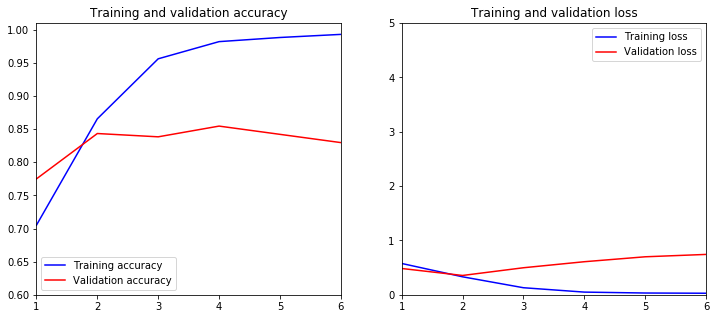

In [126]:
import matplotlib.pyplot as plt

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training accuracy')
    plt.plot(x, val_acc, 'r', label='Validation accuracy')
    plt.axis([1, 6, 0.6, 1.01])
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.axis([1, 6, 0, 5])
    plt.title('Training and validation loss')
    plt.legend()

%matplotlib inline
plot_history(history)

In [46]:
%%time
from keras.preprocessing.text import Tokenizer

sample = ['nonton','pengin sendirian']

tokens = [word_tokenize(sen) for sen in d.konten]

X = tokenizer.texts_to_sequences(tokens)
X = sequence.pad_sequences(X, padding='post', maxlen=maxlen)

y_sample = model.predict(X,batch_size=1,verbose=True)

print('Prediction: ',y_sample)

20/20 [==============================] - 0s 6ms/step
Prediction:  [[9.9894899e-01 1.0510816e-03]
 [3.2120775e-11 1.0000000e+00]
 [9.9827302e-01 1.7269817e-03]
 [9.9975199e-01 2.4806967e-04]
 [1.0592728e-08 1.0000000e+00]
 [3.3826379e-06 9.9999666e-01]
 [5.3134888e-02 9.4686514e-01]
 [9.9958318e-01 4.1687005e-04]
 [9.9963939e-01 3.6054550e-04]
 [1.4049165e-05 9.9998593e-01]
 [7.3509967e-01 2.6490039e-01]
 [9.9984932e-01 1.5071507e-04]
 [9.8709905e-05 9.9990129e-01]
 [9.9980265e-01 1.9734961e-04]
 [9.9986708e-01 1.3286316e-04]
 [1.1392741e-09 1.0000000e+00]
 [9.3718499e-01 6.2815033e-02]
 [9.9971515e-01 2.8485749e-04]
 [9.9070907e-01 9.2909755e-03]
 [9.9971646e-01 2.8355635e-04]]
Wall time: 202 ms


In [47]:
print(y_sample[4].argmax())

1


In [ ]:
class_sentimen = ['POSITIF','NEGATIF','NETRAL']

In [ ]:
for i in range(y_sample.shape[0]):
  print(str(i) + " " + class_sentimen[y_sample[i].argmax()])

0 NETRAL
1 NETRAL
2 NEGATIF
3 NEGATIF
4 NEGATIF
5 NEGATIF
6 NEGATIF
7 NEGATIF
8 NEGATIF
9 POSITIF
10 NEGATIF
11 NETRAL
12 NEGATIF
13 NETRAL
14 NEGATIF
15 NEGATIF


In [ ]:
data=["bagus"]

In [ ]:
from bs4 import BeautifulSoup
import string
import numpy as np
import pandas as pd
import pickle
from collections import defaultdict
import re
from bs4 import BeautifulSoup
import sys
import os

In [ ]:
data = np.array(data)
texts = []

for i in range(data.shape[0]):
  text = BeautifulSoup(data[i])
  texts.append(str(text.get_text().encode()))

In [ ]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\fak\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
sequences = tokenizer.texts_to_sequences(data)

word_index = tokenizer.word_index
print('Number of Unique Tokens',len(word_index))

Number of Unique Tokens 838


In [ ]:
print(data)

['bagus']


In [ ]:
test_cnn_data = pad_sequences(sequences, maxlen=maxlen)
x_test = test_cnn_data
print(x_test)

[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 8]]


In [ ]:
prediksi = model.predict(x_test, batch_size=1)

In [ ]:
print (prediksi)

[[0.26773286 0.42862236 0.52048594]]


In [ ]:
for i in range(prediksi.shape[0]):
  print(str(i) + " " + class_sentimen[prediksi[i].argmax()])

0 NETRAL


In [ ]:
model.save('/content/drive/My Drive/Skripsi/crawling/modelcnn_v1.h5')

In [127]:
model_json = model.to_json()
with open('D:\Tugas\Skripsi\model\model_cnn3class_kim_v7.json','w') as json_file:
    json_file.write(model_json)
model.save_weights("D:\Tugas\Skripsi\model\model_cnn3class_kim_v7.h5")
print("Model saved to disk")

Model saved to disk


In [128]:
import pickle

hhhh

In [129]:
with open('D:/Tugas/Skripsi/model/tokenizer_model_cnn3class_kim_v7.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

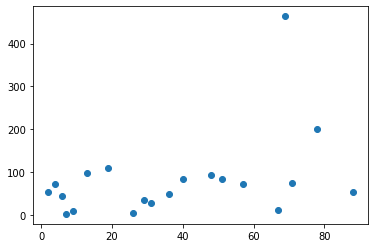

In [1]:
import matplotlib.pyplot as plt
x = [2,4,6,7,9,13,19,26,29,31,36,40,48,51,57,67,69,71,78,88]
y = [54,72,43,2,8,98,109,5,35,28,48,83,94,84,73,11,464,75,200,54]
plt.scatter(x,y)
plt.show()

In [294]:
pd.DataFrame.from_dict(data_test).to_csv("{}.csv".format('datauji_sent+spam'))

In [83]:
from sklearn.cluster import MiniBatchKMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

vec = TfidfVectorizer()
vec.fit(d.Text_Final)
features = vec.transform(d.Text_Final)

In [128]:
cls = MiniBatchKMeans(n_clusters=3)
cls.fit(features)

MiniBatchKMeans(batch_size=100, compute_labels=True, init='k-means++',
                init_size=None, max_iter=100, max_no_improvement=10,
                n_clusters=3, n_init=3, random_state=None,
                reassignment_ratio=0.01, tol=0.0, verbose=0)

In [129]:
print(cls.predict(features))

# to get cluster labels for the dataset used while
# training the model (used for models that does not
# support prediction on new dataset).
cls.labels_

[1 1 0 ... 0 1 2]


array([1, 1, 0, ..., 0, 1, 2])

In [130]:
pca = PCA(n_components=2, random_state=0)
reduced_features = pca.fit_transform(features.toarray())

# reduce the cluster centers to 2D
reduced_cluster_centers = pca.transform(cls.cluster_centers_)

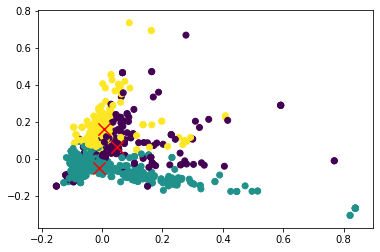

In [139]:
plt.scatter(reduced_features[:,0], reduced_features[:,1], c=cls.predict(features))
plt.scatter(reduced_cluster_centers[:, 0], reduced_cluster_centers[:,1], marker='x', s=150, c='r')

In [132]:
po = []
for l in d.label:
    if l == 'Positif':
        po.append(1)
    if l == 'Negatif':
        po.append(0)
    if l == 'Netral':
        po.append(2)
d['lab'] = po
y = d['lab']

In [136]:
from sklearn.metrics import homogeneity_score
homogeneity_score(po, cls.predict(features))

0.03233154854234482

In [134]:
from sklearn.metrics import silhouette_score
silhouette_score(features, labels=cls.predict(features))

0.006061230985877814